In [38]:
import numpy as np
import matplotlib.pyplot as plt
import myFunctions as fct
from scipy.interpolate import interp2d
from scipy.fft import fft
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid

data = fct.import_mat("C:/Users/javie/Desktop/Trabajo/Master/TFM/Data_analysis/KFOLD_validation/results_d_opt_12/encoded_patients_4_12.mat", "encoded_patients_4_12")
J_pp = fct.get_FC(data)
J_t = fct.average_FC(J_pp)


def hopf_model(eqs, sig, t_rates, J, G, a, X, Y, w_d, tps, t):
    """
    Standard Hopf model with *dim* nodes
    :param eqs: resting state value for each node (matrix of shape (2,dim))
    :param sig: noise intensity for each node (vector of shape (dim,))
    :param a: bifurcation parameter (vector of shape (dim,) OR just a scalar)
    :param t_rates: timerate (in Hz) for each node (i.e return to equilibrium speed) (vector of shape (dim,)) 
    :param J: connectivity matrix between nodes (shape (dim,dim)) 
    :param G: global coupling factor--Initial condition to modify
    :param X, Y: state of the system at time t (vectors of shape (dim,) real and imaginary parts)
    :param w_d: noise matrix (shape (dim, simulation duration))
    :param tps: time vector (shape (simulation duration,))
    :param t: time point
    :return: Returns dX, dY (vectors of shape (dim,)) increment from t to t+dt for the numerical integration
    """
    
    dim = len(eqs)
    xidx = np.arange(0, dim, 1)
    interpolated = interp2d(tps, xidx, w_d)
    w_dt = interpolated(t, xidx)

    dX = (a - ( X - eqs)**2 - (Y - eqs)**2)*(X - eqs) - t_rates*(Y - eqs) + G*(np.matmul(J.transpose(), (X - eqs)) - (sum(J).transpose())*(X - eqs)) + sig * w_dt[:, 0]
    dY = (a - (X-eqs)**2 - (Y-eqs)**2)*(Y-eqs) + t_rates*(X - eqs) + G*(np.matmul(J.transpose(), (Y - eqs)) - (sum(J).transpose())*(Y - eqs)) + sig * w_dt[:, 0]

    return dX, dY


def simulate(patient, model, duration, dt, G=1.0, a=-0.2):
    """
    Numerical integration of the model 'model' for the patient 'patient'
    :param patient: Patient dataclass containing all the patient's information necessary to run the model
    :param model: Choice of model equations (hopf_model, linear_model or stp_model)
    :param duration: duration (in s) of the simulation
    :param dt: timestep for the simulation
    :param G: global coupling factor
    :param a: bifurcation parameter (vector of shape (dim,) OR just a scalar, only if model=hopf_model)
    :return: *dim* simulated timeseries of length *duration/dt* (i.e. *duration* seconds)
    """

    
    #The following lines are made to calculate the SEF, which I implemented as the time rates = omega (t_rates here)
    
    L = len(data[0, 0, :])   #length of data
    Ts = 2    #sampling rate                                  
    Fs = 1/Ts #sampling freq                                              
    Fn = Fs/2 #Nyquist Frequency                                          
    Fv = np.linspace(0, 1, int(np.fix(L/2))+1)*Fn   #Frequency Vector
    Iv = np.arange(len(Fv)) #index vector
    Fourier = fft(patient, axis = 1)/L #Fourier Transform (Along Rows Of Matrix)
    Fouriers = np.sum(np.abs(Fourier), axis=0)    #Power Spectrum
    IntSpectrum =  cumulative_trapezoid(Fouriers[Iv], Fv) #Numeric Integration-seems to be deprecated for some versions
    SEF = interp1d(IntSpectrum, Fv[:-1], kind='linear')(0.95*IntSpectrum[-1]) #SEF calculation
  
    J = J_pp[0]
    t_rates = SEF
    sig = np.array([0.04] * 12)
    
    eqs = np.zeros((patient.shape[0])) 
    for i in range(patient.shape[0]):
        eqs[i] = np.mean(patient[i, :])

    dim = len(eqs)

    # Time sampling
    N = int(np.floor(duration / dt))
    time = np.zeros((N, 1))
    for i in range(0, N):
        time[i] = dt * (i - 1)

    # Noise matrix (1/sqrt(dt) if RK4) 
    w_dot = np.random.randn(dim, N)

    if model == hopf_model:
        X = np.zeros((dim, N))
        Y = np.zeros((dim, N))
        X[:, 0] = eqs
        Y[:, 0] = eqs
        for i in range(0, N - 1):
            dX, dY = model(eqs, sig, t_rates, J, G, a, X[:, i], Y[:, i], w_dot, time, time[i])
            X[:, i + 1] = X[:, i] + dt * dX
            Y[:, i + 1] = Y[:, i] + dt * dY
        return X, time

#This I made it because I don't know how to do it differently, so I splitted in three lines, but a more optimal way can be found
if __name__ == '__main__':
    XX0, tt0 = simulate(data[0,:,:], hopf_model, duration=300, dt=0.1, G=0.1, a=0.5)
if __name__ == '__main__':
    XX1, tt1 = simulate(data[0,:,:], hopf_model, duration=300, dt=0.1, G=0.1, a=-0.5)
if __name__ == '__main__':
    XX2, tt2 = simulate(data[0,:,:],hopf_model, duration=300, dt=0.1, G=0.1, a=0)

C:\Users\javie\AppData\Local\Temp\ipykernel_14432\851175041.py:32: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interpolated = interp2d(tps, xidx, w_d)
C:\Users\javie\AppData\Local\Temp\ipykernel_14432\851175041.py:33: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2

Following cells are designed to plot results. First three cells for all nodes, for different values of 'a'.

Following 2 cells for plotting an individual node.

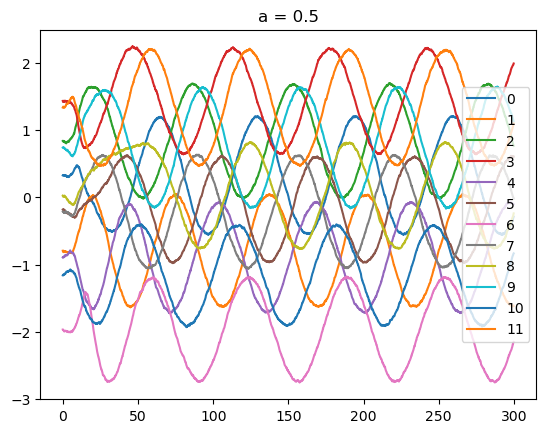

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=1)
for i in range(12):
    axs.plot(tt0, XX0[i,:], label = str(i))
    handles, labels = axs.get_legend_handles_labels()
    axs.set_title('a = 0.5')
    axs.legend(labels, loc = 'right')
plt.show()

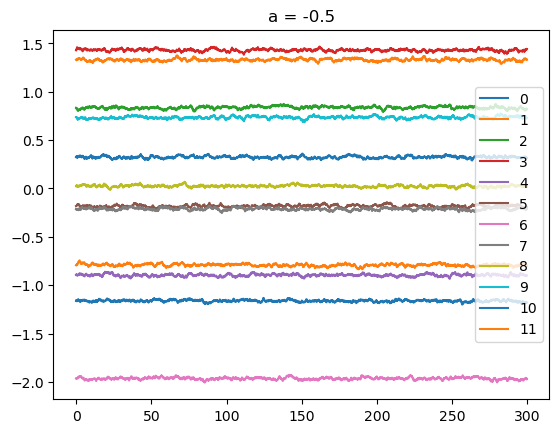

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=1)
for i in range(12):
    axs.plot(tt0, XX1[i,:], label = str(i))
    handles, labels = axs.get_legend_handles_labels()
    axs.set_title('a = -0.5')
    axs.legend(labels, loc = 'right')
plt.show()

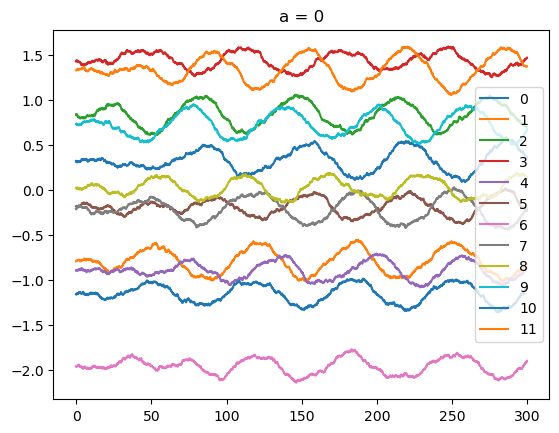

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=1)
for i in range(12):
    axs.plot(tt0, XX2[i,:], label = str(i))
    handles, labels = axs.get_legend_handles_labels()
    axs.set_title('a = 0')
    axs.legend(labels, loc = 'right')
plt.show()

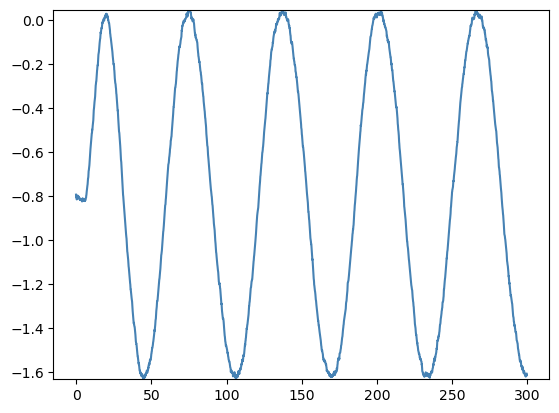

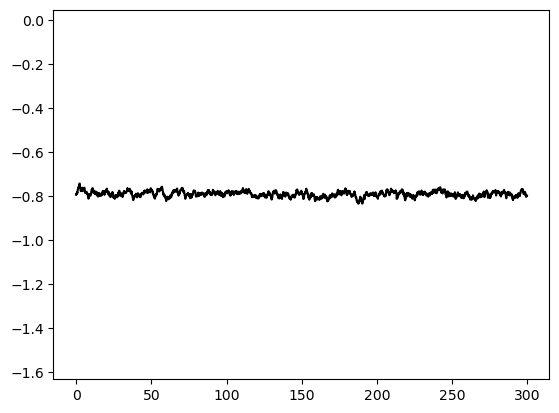

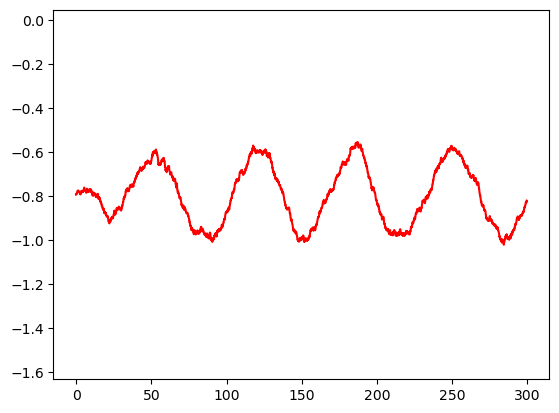

In [42]:

plt.plot(tt0[:], XX0[1,:], label = 'a=0.4', c = 'steelblue')
plt.ylim(XX0[1,:].min(), XX0[1,:].max())
#plt.savefig('Hopf1.jpg', dpi = 300)
plt.show()

plt.plot(tt1[:], XX1[1,:], label = 'a=-0.4', c = 'black')
plt.ylim(XX0[1,:].min(), XX0[1,:].max())
#plt.savefig('Hopf2.jpg', dpi = 300)
plt.show()

plt.plot(tt2[:], XX2[1,:], label = 'a=-0.03', c = 'red')
plt.ylim(XX0[1,:].min(), XX0[1,:].max())
#plt.savefig('Hopf3.jpg', dpi = 300)
plt.show()

#handles, labels = axs.get_legend_handles_labels()
#axs.legend(labels)



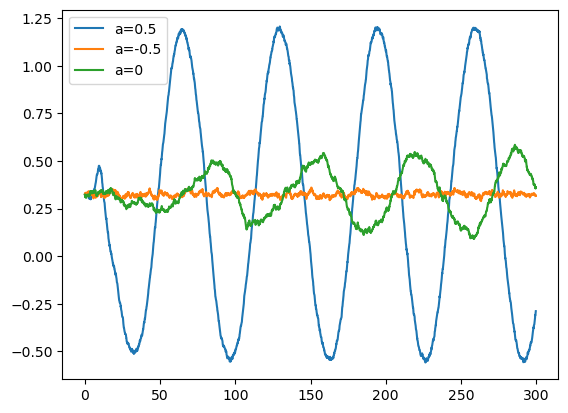

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=1)
axs.plot(tt0, XX0[0,:], label = 'a=0.5')
axs.plot(tt1, XX1[0,:], label = 'a=-0.5')
axs.plot(tt2, XX2[0,:], label = 'a=0')
handles, labels = axs.get_legend_handles_labels()
axs.legend(labels)
plt.show()

Now I plot a matrix whose: 
    upper diagonal region is the empirical FC matrix
    lower diagonal region is the simulated FC matrix by the Hopf model
    
I have added print lines so its easier to follow what I do with the functions.

In [44]:
from nilearn.connectome import ConnectivityMeasure

print(XX2.shape)
data = np.transpose(XX2)
print(data.shape)
data = np.expand_dims(data, axis=0)
print(data.shape)

correlation_measure = ConnectivityMeasure(kind='correlation', discard_diagonal = True)
correlation_matrix = correlation_measure.fit_transform(data)[0]

(12, 3000)
(3000, 12)
(1, 3000, 12)


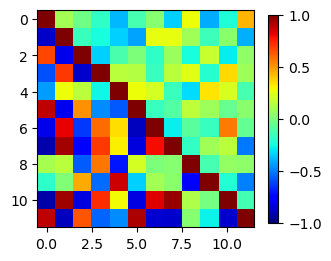

In [45]:
import numpy as np
import matplotlib.pyplot as plt

matrix = np.zeros((12, 12))
for i in range(0, 12):
    for j in range(0, 12):
        if i == j:
            matrix[i,j] = 1
        if i < j:
            matrix[i,j] = J_pp[0, i, j]
        if i > j:
            matrix[i,j] = correlation_matrix[i,j]
plt.figure(1, figsize = (3.5, 3))
plt.imshow(matrix, interpolation="nearest", cmap="jet", vmax=1, vmin=-1)
plt.colorbar(shrink = 0.9)